<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>
<h1> 1. Business Problem </h1>
<h2> 1.1 Description </h2>
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 
__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 



<h2> 1.2 Source</h2>
- Source : https://www.kaggle.com/c/quora-question-pairs

<h2>1.3 Real world/Business Objectives and Constraints </h2>
1. The cost of a mis-classification can be very high.

2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.

3. No strict latency concerns.

4. Interpretability is partially important.

<h1>2. Machine Learning Problem </h1>
<h2> 2.1 Data </h2>
<h3> 2.1.1 Data Overview </h3>
<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>
<h2> 2.2 Mapping the real world problem to an ML problem </h2>
<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>
Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://sachinkalsi.github.io/blog/category/ml/2018/08/20/top-8-performance-metrics-one-should-know.html#log-loss
* Binary Confusion Matrix : https://sachinkalsi.github.io/blog/category/ml/2018/08/20/top-8-performance-metrics-one-should-know.html#confusion-matrix

<h2> 2.3 Train and Test Construction </h2>

<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import distance
from tqdm import tqdm
import time
from fuzzywuzzy import fuzz
import re
from string import punctuation
import pickle
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [12]:
def save_file(data, file_name):
    with open(file_name+'.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_file(file_name):
    with open(file_name+'.pickle', 'rb') as handle:
        return pickle.load(handle)

In [2]:
# Read data
df = pd.read_csv('train.csv')

In [286]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [258]:
df.shape

(404290, 6)

## Exploratory Data Analysis

<h3> Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

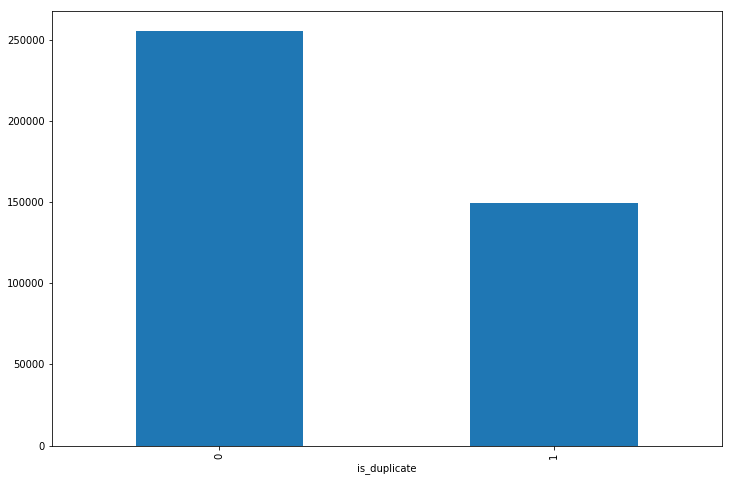

In [11]:
plt.figure(figsize=(12,8))
df.groupby("is_duplicate")['id'].count().plot.bar()

In [16]:
print('Total number of question pairs for training:\n   {}'.format(len(df)))
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Total number of question pairs for training:
   404290
~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


### Number of unique questions

In [19]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



### Number of occurrences of each question

Maximum number of times a single question is repeated: 157



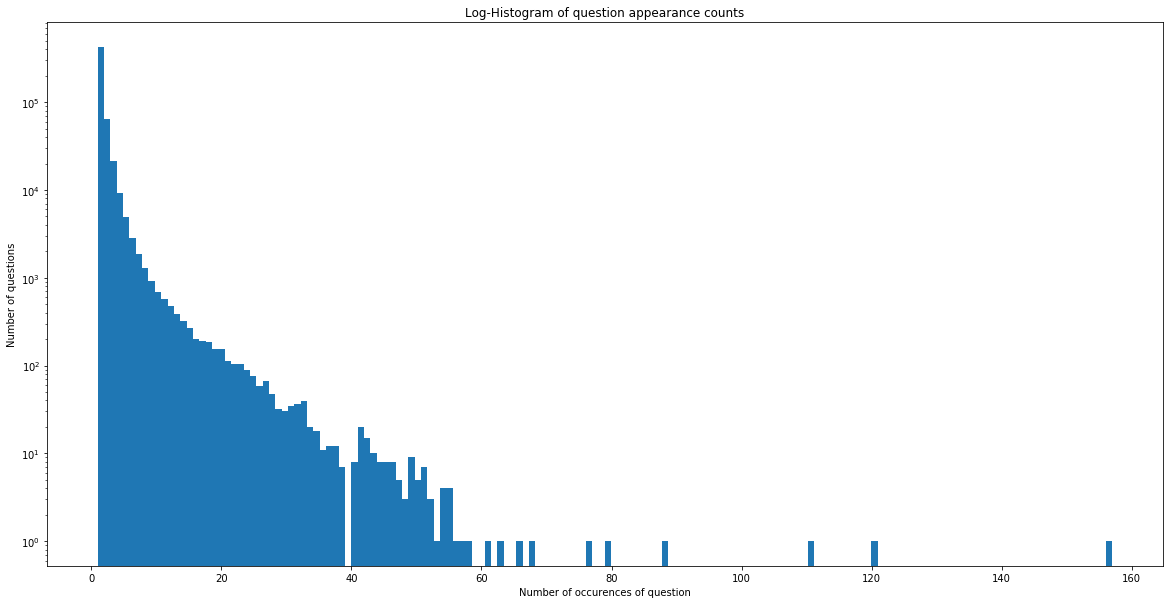

In [20]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### Checking for NULL values

In [3]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


- There are two rows with null values in question2 

In [4]:
# Filling the null values with ' '
df = df.fillna('')
df.isnull().values.any()

False

In [5]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

## Basic Feature Extraction (before cleaning) 

 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [6]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(str(row).split(" ")))

In [7]:
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

In [8]:
def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

In [9]:
df['word_share'] = df['word_Common']/df['word_Total']
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [10]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### Save df

In [14]:
save_file(df, 'pickle/df_without_preprocessing')

## Preprocessing
1. <b>Clean the text:</b> convert words like "won't", "I'm" etc to "will not", "I am " etc
2. Remove HTML Tags
3. Remove punctuations

In [15]:
STOP_WORDS = stopwords.words("english")
def clean_text(text):
    text=text.lower()
    text = text.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    text = re.sub(r"([0-9]+)000000", r"\1m", text)
    text = re.sub(r"([0-9]+)000", r"\1k", text)
    return text

def remove_html_tags(text):
    return re.compile(r'<.*?>').sub('', text)

def remove_punctuation(text):
    final_text = ''
    for c in text:
        if c not in punctuation:
            final_text += c
        else:
            final_text += ' '
    return final_text.strip()

def preprocess_text(text):
    text=text.strip()
    text=text.lower()
    text=clean_text(text)
    text=remove_html_tags(text)
    text=remove_punctuation(text)
    return text

In [16]:
start_time = time.time()
df['question1'] = df.apply(lambda row: preprocess_text(row['question1']), axis=1)
df['question2'] = df.apply(lambda row: preprocess_text(row['question2']), axis=1)
print('total time taken in seconds: ', time.time()-start_time)

total time taken in seconds:  40.9355583190918


# questions having 1 word

In [17]:
one_word_questions = set(df['question1'][df['q1_n_words'] ==1].tolist() + df['question2'][df['q2_n_words'] ==1].tolist())

In [18]:
print("Number of questions having 1 word:", len(one_word_questions))
print("Sample questions having one word:", list(one_word_questions)[:10])

Number of questions having 1 word: 40
Sample questions having one word: ['', 'removed', 'sss', 'spam', 'is', 'my', 'cloning', 'aaas', 'what', 'marriage']


### As you can observe, one can't say anything about the questions like "how", "hh" etc so lets delete these rows

In [19]:
df.shape

(404290, 17)

In [21]:
ids_tobe_deleted = set(df['id'][df['q1_n_words'] ==1].tolist() + df['id'][df['q2_n_words'] ==1].tolist())
df=df.drop(ids_tobe_deleted, axis=0)
df = df.reset_index()

In [24]:
print("number of question pairs deleted: ", len(ids_tobe_deleted))

number of question pairs deleted:  91


In [22]:
df.shape

(404199, 18)

In [25]:
df.head()

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [26]:
save_file(df, 'pickle/df_cleaned_text')

In [27]:
df = df[:100000]

In [32]:
SAFE_DIV = 0.0001
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [305]:
save_file(df, 'pre_nlp_features_df')

In [33]:
start_time = time.time()
if os.path.isfile('pickle/df_nlp_features.pickle'):
    df = read_file('pickle/df_nlp_features')
    df = df.fillna('')
    df = df.drop(['index', 'level_0', 'id'], axis=1)
else:
    print("Extracting features for train:")
    df = extract_features(df)
    save_file(df, 'pickle/df_nlp_features')
print('total time taken in seconds: ', time.time()-start_time)

Extracting features for train:
total time taken in seconds:  487.4652919769287


In [35]:
df.head()

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982456
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,74,0.588235
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,46,0.169492
3,3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,0,1,1,50,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,11,0.040000
4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,55,0.153846


<h3> Analysis of extracted features </h3>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

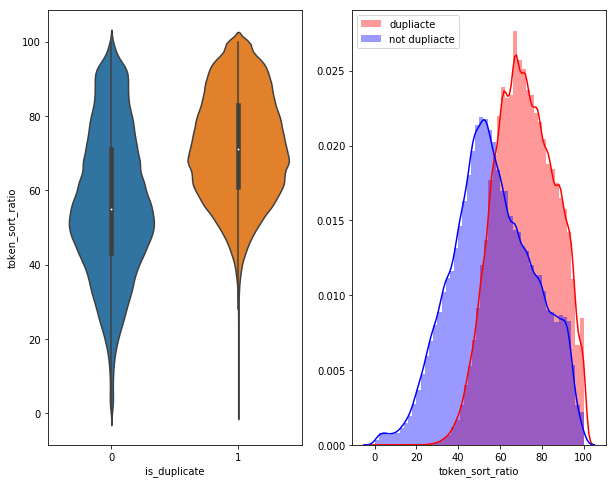

In [315]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "dupliacte", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "not dupliacte" , color = 'blue' )
plt.legend()
plt.show()

### Observations:
1. Most of the duplicate questions are having higher token_sort_ratio
2. But still there is overlap between duplicate questions & non_duplicate questions for the range of token_sort_ratio values from 50 to 85

In [128]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]
duplicate_questions = df_duplicate["question1"].tolist() + df_duplicate["question2"].tolist()
non_duplicate_questions = dfp_nonduplicate["question1"].tolist() + dfp_nonduplicate["question2"].tolist()
duplicate_questions_text = ' '.join(duplicate_questions)
non_duplicate_questions_text = ' '.join(non_duplicate_questions)

Word Cloud for Duplicate Question pairs


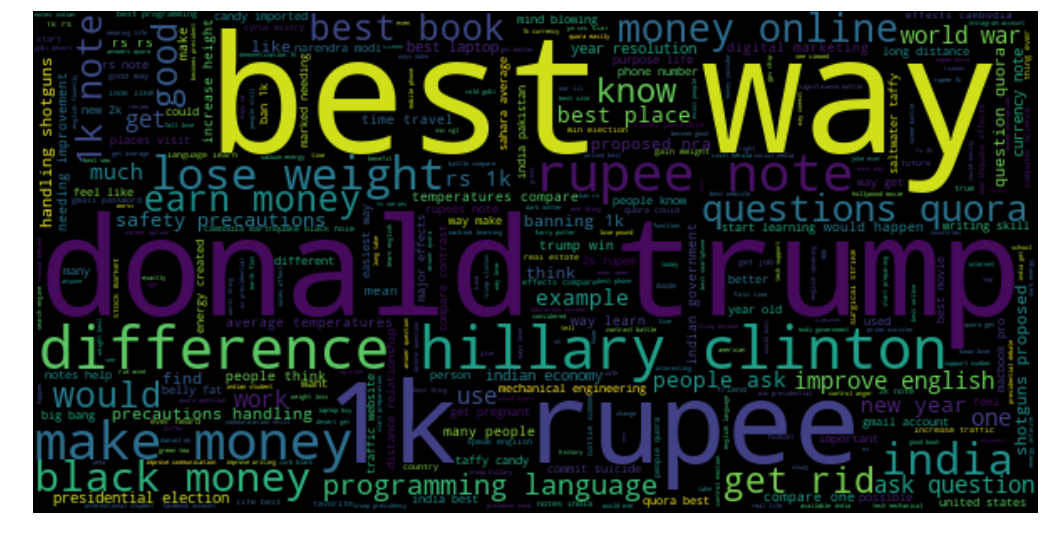

In [130]:
plt.figure(figsize=(18,10))
wc = WordCloud(width=600, height=300, background_color="black",max_words=len(duplicate_questions_text), stopwords=stopwords.words('english'))
wc.generate(duplicate_questions_text)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non Duplicate Question pairs


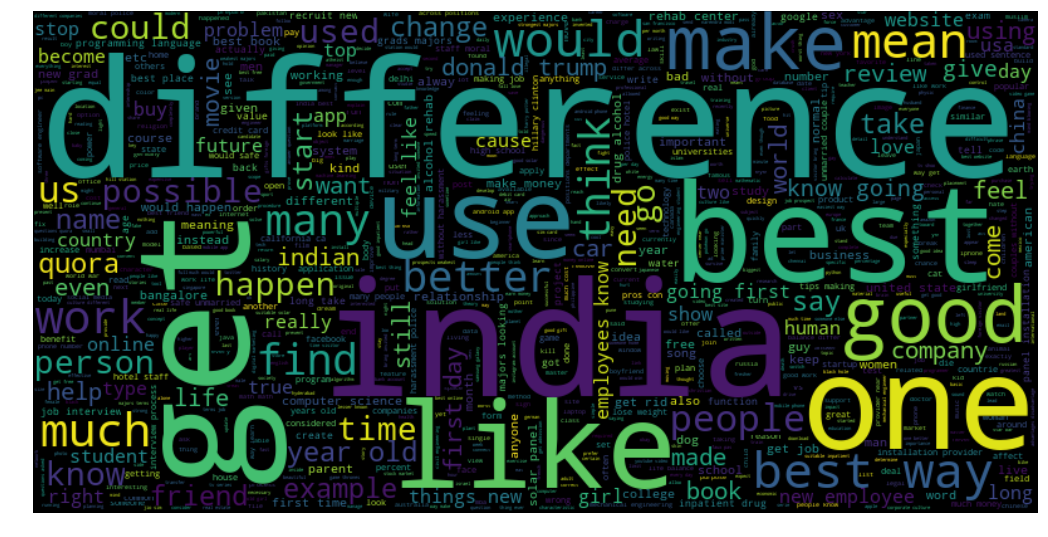

In [131]:
plt.figure(figsize=(18,10))
wc = WordCloud(width=800, height=400, background_color="black",max_words=len(non_duplicate_questions_text), stopwords=stopwords.words('english'))
wc.generate(non_duplicate_questions_text)
print ("Word Cloud for Non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Observations
1. In word cloud of duplicate questions, words like "best way", "donald trump", "1k rupee" occurs a lot
2. In word cloud of non_duplicate questions, words like "india", "difference", "best", "good", "like" occurs a lot

### TfIdf Word2Vec

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [36]:
df_without_preprocessing=read_file('pickle/df_without_preprocessing')

In [37]:
df_without_preprocessing.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### Downscaling

In [39]:
df.shape

(100000, 33)

In [40]:
df_without_preprocessing.shape

(404290, 17)

In [41]:
df_without_preprocessing = df_without_preprocessing[:100000]

In [43]:
df_without_preprocessing.shape

(100000, 17)

In [316]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982456
1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,74,0.588235
2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,46,0.169492
3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,0,1,1,50,65,11,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,11,0.040000
4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,13,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,55,0.153846


In [47]:
nlp = spacy.load('en_core_web_sm') # 35 MB

In [88]:
# merge texts
start_time = time.time()
questions = list(df_without_preprocessing['question1']) + list(df_without_preprocessing['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
print('total time taken in seconds: ', time.time()-start_time)

total time taken in seconds:  3.883979082107544


In [48]:
print("Total words:", len(word2tfidf))
# Refer https://spacy.io/models/en#en_core_web_sm for details
doc = nlp('Test')
for w in doc:
    print("The length of the vector size: ", len(w.vector))

Total words: 56767
The length of the vector size:  384


In [49]:
start_time = time.time()
vecs1 = []
for qu1 in list(df_without_preprocessing['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        vec1 = word1.vector
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_without_preprocessing['q1_feats_m'] = list(vecs1)
print('total time taken in seconds: ', time.time()-start_time)

total time taken in seconds:  1142.5307841300964


In [50]:
start_time = time.time()
vecs2 = []
for qu2 in list(df_without_preprocessing['question2']):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_without_preprocessing['q2_feats_m'] = list(vecs2)
print('total time taken in seconds: ', time.time()-start_time)

total time taken in seconds:  1159.4465560913086


In [51]:
#### save vectors to a pickle files
save_file(list(vecs1), 'pickle/vecs_q1')
save_file(list(vecs2), 'pickle/vecs_q2')

In [89]:
#### Read vectors from pickle file 
vecs1 = read_file('pickle/vecs_q1')
vecs2 = read_file('pickle/vecs_q2')
df_without_preprocessing['q1_feats_m'] = list(vecs1)
df_without_preprocessing['q2_feats_m'] = list(vecs2)

In [90]:
dfnlp = read_file('pickle/df_nlp_features')
dfppro = read_file('pickle/df_without_preprocessing')

In [53]:
dfnlp.head(2)

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982456
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,74,0.588235


In [54]:
dfppro.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [91]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df_without_preprocessing.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [92]:
df3_q1['id']=df1['id']
df3_q2['id']=df1['id']
df1  = df1.merge(df2, on='id',how='left')
df2  = df3_q1.merge(df3_q2, on='id',how='left')
df_tfidf_w2v  = df1.merge(df2, on='id',how='left')
save_file(df_tfidf_w2v, 'pickle/df_tfidf_w2v')

### Read df_tfidf_w2v file

In [57]:
df_tfidf_w2v = read_file('pickle/df_tfidf_w2v')

In [70]:
df_tfidf_w2v.shape

(100000, 808)

In [61]:
df_tfidf_w2v.head(2)

,index,id,is_duplicate,freq_qid1_x,freq_qid2_x,q1len_x,q2len_x,q1_n_words_x,q2_n_words_x,word_Common_x,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,1,1,66,57,14,12,10.0,...,16.188513,33.233714,6.971698,-14.820823,15.534948,8.205958,-25.256609,1.552820,1.651823,0.267471
1,1,1,0,4,1,51,88,8,13,4.0,...,-4.432305,-4.367795,41.101276,-0.930742,-15.686241,-7.276000,2.756571,-7.351971,3.103776,0.440434


In [71]:
y_true = df_tfidf_w2v['is_duplicate']
df_tfidf_w2v.drop(['id','index','is_duplicate'], axis=1, inplace=True)

In [72]:
df_tfidf_w2v.shape

(100000, 805)

In [73]:
df_tfidf_w2v.head(2)

,freq_qid1_x,freq_qid2_x,q1len_x,q2len_x,q1_n_words_x,q2_n_words_x,word_Common_x,word_Total_x,word_share_x,freq_q1+q2_x,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,...,16.188513,33.233714,6.971698,-14.820823,15.534948,8.205958,-25.256609,1.552820,1.651823,0.267471
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,...,-4.432305,-4.367795,41.101276,-0.930742,-15.686241,-7.276000,2.756571,-7.351971,3.103776,0.440434


In [74]:
start_time = time.time()
columns = list(df_tfidf_w2v.columns)
for i in columns:
    df_tfidf_w2v[i] = df_tfidf_w2v[i].apply(pd.to_numeric)
print('total time taken in seconds: ', time.time()-start_time)

total time taken in seconds:  383.4112129211426


In [75]:
# convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

In [79]:
df_tfidf_w2v = df_tfidf_w2v.fillna(0.0)

In [83]:
print("shape of the df_tfidf_w2v: ", df_tfidf_w2v.shape)

shape of the df_tfidf_w2v:  (100000, 805)


In [82]:
len(y_true)

100000

In [87]:
#save file
save_file(y_true, 'pickle/y_true_100K')
save_file(df_tfidf_w2v, 'pickle/df_tfidf_w2v_final')

### Util function

<i>P.S:</i> Refer my [blog](https://sachinkalsi.github.io/blog/category/ml/2018/08/20/top-8-performance-metrics-one-should-know.html#confusion-matrix) to know more about confusion matrix,  Precision & Recall

In [93]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0, 1]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")    
    plt.show()

## Machine Learning Models

In [95]:
df_tfidf_w2v_final=read_file('pickle/df_tfidf_w2v_final')

In [96]:
data = df_tfidf_w2v_final[:30000]
y_true = read_file('y_true_100K')[:30000]

In [97]:
print("Number of data points in data :",data.shape)

Number of data points in data : (30000, 805)


In [98]:
len(y_true)

30000

### Random train test split 70:30

In [102]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [103]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (21000, 805)
Number of data points in test data : (9000, 805)


In [104]:
train_y_values = Counter(y_train)
test_y_values = Counter(y_test)

In [105]:
test_y_values

Counter({0: 5652, 1: 3348})

In [106]:
train_y_values

Counter({0: 13188, 1: 7812})

In [107]:
print("Class 1 percentage in train set: ", train_y_values[1]/X_train.shape[0])
print("Class 1 percentage in test set: ", test_y_values[1]/X_test.shape[0])

Class 1 percentage in train set:  0.372
Class 1 percentage in test set:  0.372


In [108]:
print("Class 0 percentage in train set: ", train_y_values[0]/X_train.shape[0])
print("Class 0 percentage in test set: ", test_y_values[0]/X_test.shape[0])

Class 0 percentage in train set:  0.628
Class 0 percentage in test set:  0.628


### Building a random model with weighted tfidf - word2vec featurisation (Finding worst-case log-loss) (30K data points)

Log loss on Test Data using Random Model 0.8818543066839006


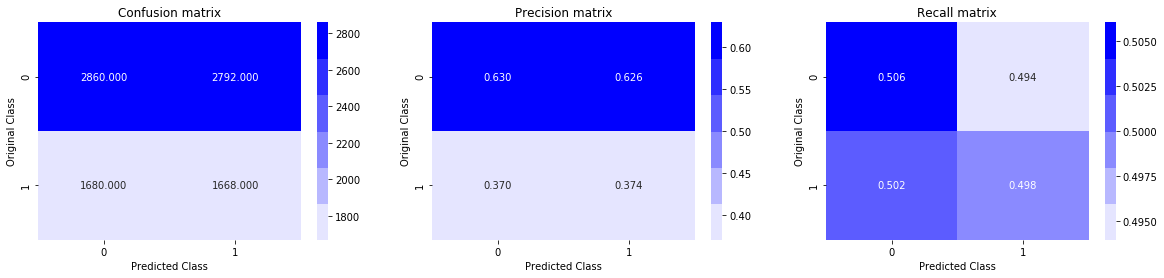

In [109]:
test_len=len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Observations
1. For a randoma model (which guesses randomly), the log loss is 0.88
2. 0.88 is the worst log loss a model can achieve. So whatever the model we are going to build, the log loss has to be less than 0.88, other wise it would be equivalent to a random model
3. Precision values has to be improved. TPR has be improved

### Logistic Regression with hyperparameter tuning- with weighted tfidf - word2vec featurisation (30K data points)

In [446]:
[10 ** x for x in range(-4, 2)]

[0.0001, 0.001, 0.01, 0.1, 1, 10]

In [111]:
alpha = [10 ** x for x in range(-4, 2)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log',max_iter=500,tol=1e-2, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  0.0001 The log loss is: 0.5313346312273028
For values of alpha =  0.001 The log loss is: 0.5201718909528821
For values of alpha =  0.01 The log loss is: 0.5357031156900623
For values of alpha =  0.1 The log loss is: 0.5264933838679543
For values of alpha =  1 The log loss is: 0.5316925849562639
For values of alpha =  10 The log loss is: 0.5418937605360643


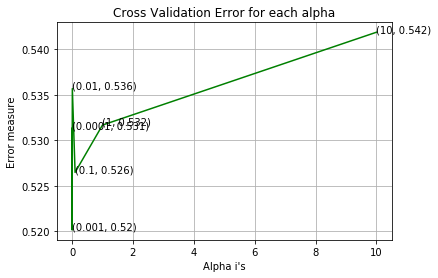

In [117]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [118]:
best_alpha = np.argmin(log_error_array)

In [119]:
print("Best alpha: ", best_alpha)

Best alpha:  1


For values of best alpha =  0.001 The train log loss is: 0.5617664479406393
For values of best alpha =  0.001 The test log loss is: 0.5741355889690225
Total number of data points : 9000


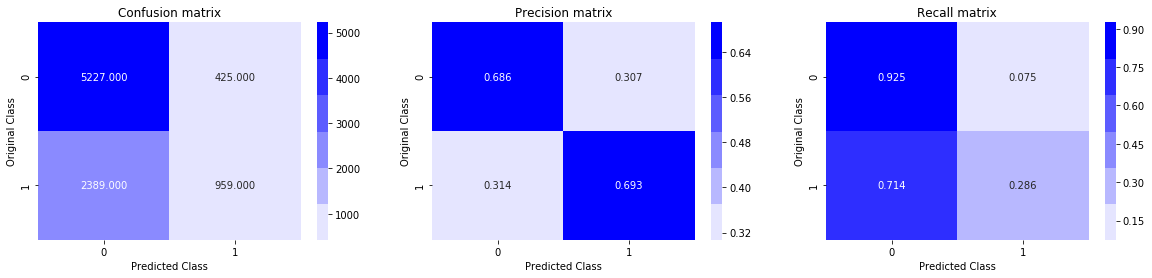

In [120]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Observations
1. Train log_loss & Test log_loss are very close, so there would be no overfitting
2. The test log_loss achieved is 0.57. Much improved from a random model
3. Precision values have been improved significantly. But improvement is much needed for the recall values. Only 28.6% of all the positive classes (is_duplicate = 1) have been predicted correctly. This value has to improve

### Linear SVM with hyperparameter tuning with weighted tfidf - word2vec featurisation (30K data points)

For values of alpha =  1e-05 The log loss is: 0.6600115435113245
For values of alpha =  0.0001 The log loss is: 0.5390215217078341
For values of alpha =  0.001 The log loss is: 0.5551674044295628
For values of alpha =  0.01 The log loss is: 0.5893134313809544
For values of alpha =  0.1 The log loss is: 0.6170740089192702
For values of alpha =  1 The log loss is: 0.6504108213486923
For values of alpha =  10 The log loss is: 0.6600115435113245


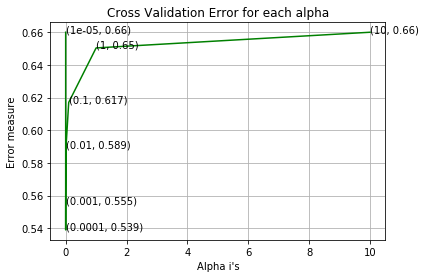

For values of best alpha =  0.0001 The train log loss is: 0.5208705003528334
For values of best alpha =  0.0001 The test log loss is: 0.5390215217078341
Total number of data points : 9000


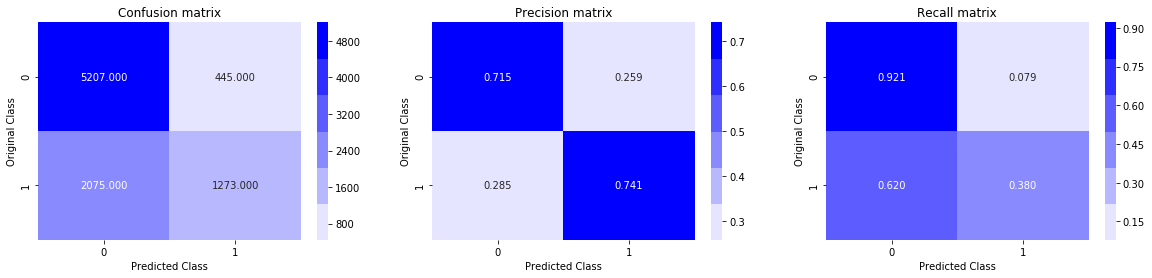

In [121]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Observations
0. Test log loss dropeed to 0.539 from 0.57 which is a good sign
1. Linear SVM performed better than Logistic regression
2. Precision & recall values have been improved in Linear SVM. But still recall values need improvement

# Logistic regression, Linear-SVM with simple TF-IDF vectors. (20K data points)

In [132]:
df_nlp_features=read_file('pickle/df_nlp_features')
y_true = df_nlp_features['is_duplicate'].values

### Downscaling of data
I did try Logistic regression & Linear-SVM with full dataset, but my system was running out of memory, so I am downscaling the data to 20K

In [133]:
df_nlp_features.head()

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982456
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,74,0.588235
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,46,0.169492
3,3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,0,1,1,50,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,11,0.040000
4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,55,0.153846


In [134]:
duplicate_ratio = df_nlp_features['is_duplicate'].value_counts()
print("ratio of number of duplicate question pairs to non duplicate question pairs BEFORE downscaling the data: ",
      np.round(duplicate_ratio[1]/(duplicate_ratio[0]+duplicate_ratio[1]),4))

ratio of number of duplicate question pairs to non duplicate question pairs BEFORE downscaling the data:  0.3726


In [135]:
duplicate_ratio = df_nlp_features[:20000]['is_duplicate'].value_counts()
print("ratio of number of duplicate question pairs to non duplicate question pairs AFTER downscaling the data: ",
      np.round(duplicate_ratio[1]/(duplicate_ratio[0]+duplicate_ratio[1]),4))

ratio of number of duplicate question pairs to non duplicate question pairs AFTER downscaling the data:  0.3738


### Since the ratio of number of duplicate question pairs to non duplicate question pairs is almost same before & after downscaling of data, we can go ahead with this data

In [137]:
df_nlp_features = df_nlp_features[:20000]
y_true = y_true[:20000]

### building TF-IDF vectors

In [142]:
questions = list(df_nlp_features['question1']) + list(df_nlp_features['question2'])
tfidf_vectors = TfidfVectorizer()
tfidf_features = tfidf_vectors.fit_transform(questions)
print('Number of dimentions for tfidf: ', tfidf_features.get_shape()[1])

Number of dimentions for tfidf:  21307


In [143]:
question1_tfidfs = []
question2_tfidfs = []
for idx in tqdm(range(df_nlp_features.shape[0])):
    question1 = str(df_nlp_features['question1'][idx])
    question2 = str(df_nlp_features['question2'][idx])
    q1_feature_vector = np.zeros([tfidf_features.get_shape()[1]])
    q2_feature_vector = np.zeros([tfidf_features.get_shape()[1]])
    
    for word in question1.split(' '):
        try:
            word_index = tfidf_vectors.vocabulary_[word]
            q1_feature_vector[word_index] = tfidf_features[0,word_index]
        except:
            continue
        
    for word in question2.split(' '):
        try:
            word_index = tfidf_vectors.vocabulary_[word]
            q2_feature_vector[word_index] = tfidf_features[0,word_index]
        except:
            continue
        
    question1_tfidfs.append(q1_feature_vector)
    question2_tfidfs.append(q2_feature_vector)

100%|██████████| 20000/20000 [00:24<00:00, 817.34it/s]


In [145]:
df= df_nlp_features.drop(['id','qid1','qid2','is_duplicate', 'question1','question2'], axis=1)
question_tfidfs = np.hstack((question1_tfidfs, question2_tfidfs))
tfidf_df = pd.DataFrame(question_tfidfs)
tfidf_df.shape

(20000, 42614)

In [146]:
df_final = pd.concat([tfidf_df, df], axis=1)

In [147]:
df_final.shape

(20000, 42641)

### Random train test split( 70:30) 

<h3>splitting data randomly into 70% train set & 30% test set</h3>

In [148]:
X_train,X_test, y_train, y_test = train_test_split(df_final, y_true, stratify=y_true, test_size=0.3)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (14000, 42641)
Number of data points in test data : (6000, 42641)


In [154]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
13692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.888879,1.0,1.0,0.0,9.0,93,88,88,83,0.459459
1407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,8.0,16.0,18,18,25,30,0.051724
18961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333331,1.0,0.0,5.0,9.5,78,70,73,87,0.405405
4993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.624992,1.0,1.0,1.0,7.5,83,76,82,76,0.565217
10818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222220,0.0,0.0,3.0,7.5,50,44,56,55,0.363636


In [150]:
Counter(y_train)

Counter({0: 8768, 1: 5232})

In [151]:
Counter(y_test)

Counter({0: 3757, 1: 2243})

In [156]:
# standardising the data
start_time = time.time()
std_scaler  = StandardScaler()
X_train  = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)
print('total time taken in seconds: ', time.time()-start_time)

total time taken in seconds:  143.99660682678223


## Logistic regression with simple TF-IDF vectors (20K data points) with hyper tuning

In [157]:
start_time = time.time()
alpha = [10 ** x for x in range(-4, 2)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log',max_iter=500,tol=1e-2, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print('total time taken in seconds: ', time.time()-start_time)

For values of alpha =  0.0001 The log loss is: 0.5106659503513578
For values of alpha =  0.001 The log loss is: 0.4253643223588802
For values of alpha =  0.01 The log loss is: 0.42410707550890964
For values of alpha =  0.1 The log loss is: 0.46287363744382454
For values of alpha =  1 The log loss is: 0.5096751463101478
For values of alpha =  10 The log loss is: 0.5350547312261508
total time taken in seconds:  1008.4327301979065


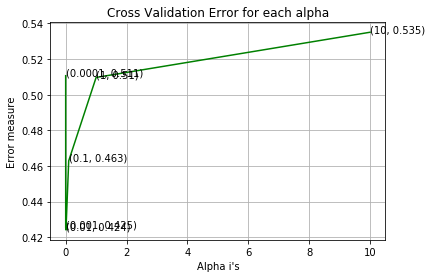

For values of best alpha =  0.01 The train log loss is: 0.42795350677751726
For values of best alpha =  0.01 The test log loss is: 0.42589284682004214
Total number of data points : 6000


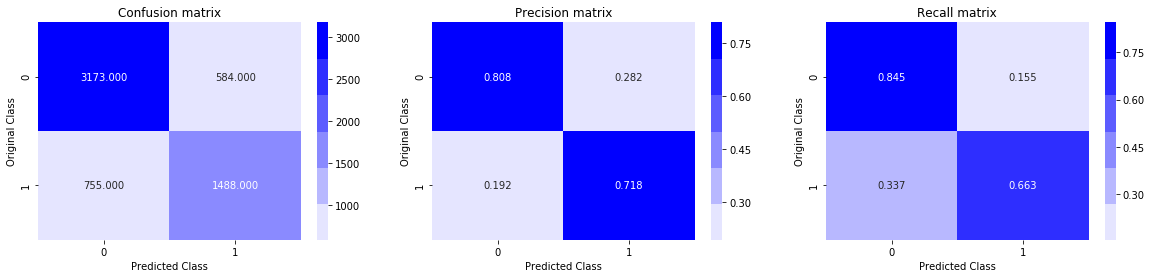

In [158]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Observations
0. Test log loss reduced to 0.425 from 0.539. But we have tried it for 30K data points
1. Train & Test log loss are very close, so there is no overfitting
2. Precision values & Recall values are good & have been improved lot from the previous models
3. Off all the points where is_duplicate=1, 33.7 % of the points have been predicted incorreclty. This number has be reduced

##  Linear SVM with simple TF-IDF vectors (20K data points) with hyper tuning

In [159]:
start_time = time.time()
alpha = [10 ** x for x in range(-5, 2)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print('total time taken in seconds: ', time.time()-start_time)

For values of alpha =  1e-05 The log loss is: 0.5625163229360337
For values of alpha =  0.0001 The log loss is: 0.4824185242010276
For values of alpha =  0.001 The log loss is: 0.42255697580939705
For values of alpha =  0.01 The log loss is: 0.4394979507992612
For values of alpha =  0.1 The log loss is: 0.5207004809013444
For values of alpha =  1 The log loss is: 0.6609644002410042
For values of alpha =  10 The log loss is: 0.6609644002410058
total time taken in seconds:  1164.0443379878998


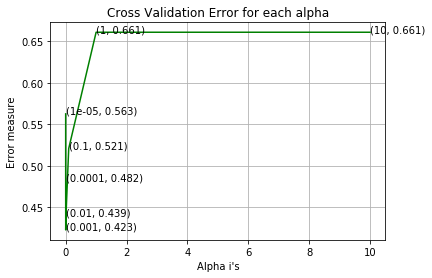

For values of best alpha =  0.001 The train log loss is: 0.42841364442644836
For values of best alpha =  0.001 The test log loss is: 0.42255697580939705
Total number of data points : 6000


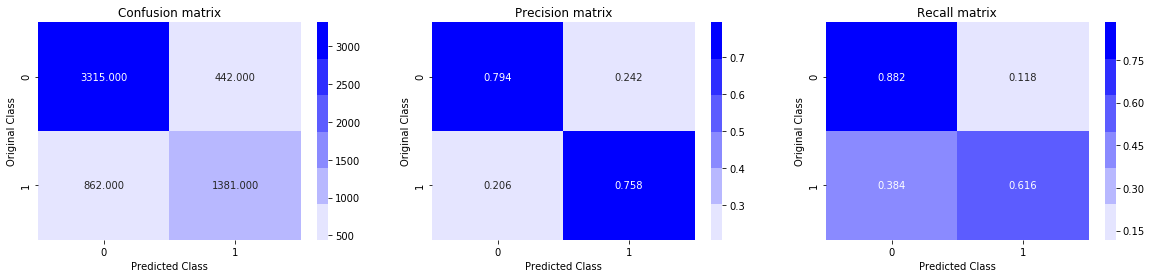

In [160]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Observations
1. Not much improvement in test log loss
2. Train & Test log loss are very close, so there is no overfitting
3. Not much improvement in Precision values or Recall values. In fact it has reduced a bit if you observe

## XgBoost (20K data points)

In [161]:
df_tfidf_w2v_final=read_file('pickle/df_tfidf_w2v_final')

In [162]:
df_tfidf_w2v_final.shape

(100000, 805)

In [163]:
data = df_tfidf_w2v_final[:20000]
y_true = read_file('y_true_100K')[:20000]

In [164]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

### Without hyper parameter

In [165]:
start_time = time.time()
x_model = xgb.XGBClassifier(
 gamma=0,
 subsample=0.8,
 nthread=4)
x_model.fit(X_train, y_train)
print('total time taken in seconds: ', time.time()-start_time)

total time taken in seconds:  65.52585911750793


The test log loss is: 0.3833678700688955


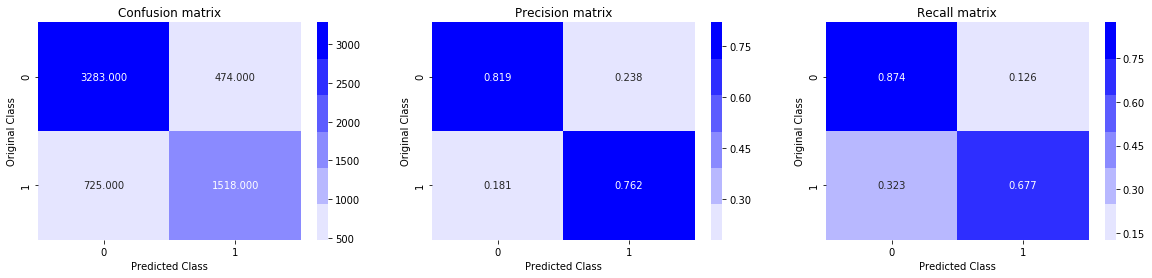

In [166]:
predicted_y = x_model.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predicted_y, labels=[0, 1], eps=1e-15))
plot_confusion_matrix(y_test, x_model.predict(X_test))

### Observations
1. Test log loss has been reduced to 0.38, which is really good
2. Precision & Recall values have also been improved

### Hyperparameter tune XgBoost using GridSearchCV to reduce the log-loss.

In [167]:
# X_train,X_test, y_train, y_test = train_test_split(df_final, y_true, stratify=y_true, test_size=0.3)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (14000, 805)
Number of data points in test data : (6000, 805)


In [168]:
start_time = time.time()
param_distributions = {
    'max_depth': np.arange(3,10,2),
    'min_child_weight': np.arange(1,6,2)
}
clf = xgb.XGBClassifier()
grid_search = GridSearchCV(clf, param_distributions,verbose=1, cv=3,pre_dispatch=None)
clf = grid_search.fit(X_train, y_train)
print('total time taken in seconds: ', time.time()-start_time)
grid_search.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 57.3min finished


total time taken in seconds:  3574.202070951462


{'max_depth': 5, 'min_child_weight': 1}

In [169]:
max_depth = grid_search.best_params_['max_depth']
min_child_weight = grid_search.best_params_['min_child_weight']

In [170]:
param_distributions = {
    'colsample_bytree': np.arange(0.2, 1.0, 0.1)
}
clf = xgb.XGBClassifier(max_depth=max_depth, min_child_weight=min_child_weight)
grid_search =GridSearchCV(clf,param_distributions,scoring='neg_log_loss', verbose=1, cv=3,pre_dispatch=None)
clf = grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 18.9min finished


{'colsample_bytree': 0.30000000000000004}

In [171]:
colsample_bytree=grid_search.best_params_['colsample_bytree']

In [172]:
param_distributions = {
    'reg_alpha': [1e-2, 0.1, 1, 100]
}
clf = xgb.XGBClassifier(max_depth=max_depth, min_child_weight=min_child_weight,colsample_bytree=colsample_bytree)
grid_search = GridSearchCV(clf, param_distributions,verbose=1,scoring='neg_log_loss', cv=3,pre_dispatch=None)
clf = grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  6.1min finished


{'reg_alpha': 1}

In [173]:
reg_alpha=grid_search.best_params_['reg_alpha']

In [174]:
param_distributions = {
    'reg_lambda': [1e-2, 0.1, 1, 100]
}
clf = xgb.XGBClassifier(max_depth=max_depth, min_child_weight=min_child_weight,colsample_bytree=colsample_bytree,reg_alpha=reg_alpha )
grid_search =GridSearchCV(clf, param_distributions,verbose=1,scoring='neg_log_loss', cv=3,pre_dispatch=None)
clf = grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  5.9min finished


{'reg_lambda': 1}

In [175]:
reg_lambda=grid_search.best_params_['reg_lambda']

In [176]:
param_distributions = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': np.arange(100, 2000, 300)
}
clf = xgb.XGBClassifier(max_depth=max_depth, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
grid_search =GridSearchCV(clf, param_distributions,verbose=1,scoring='neg_log_loss', cv=3,pre_dispatch=None)
clf = grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed: 281.5min finished


{'learning_rate': 0.01, 'n_estimators': 1600}

In [177]:
learning_rate=grid_search.best_params_['learning_rate']
n_estimators=grid_search.best_params_['n_estimators']

In [178]:
start_time = time.time()
x_model = xgb.XGBClassifier(
 learning_rate =learning_rate,
 n_estimators=n_estimators,
 max_depth=max_depth,
 min_child_weight=min_child_weight,
 gamma=0,
 subsample=0.8,
 reg_alpha=reg_alpha, reg_lambda=reg_lambda,
 colsample_bytree=colsample_bytree,nthread=4)
x_model.fit(X_train, y_train)
print('total time taken in seconds: ', time.time()-start_time)

total time taken in seconds:  635.9052588939667


The test log loss is: 0.37235400201485996


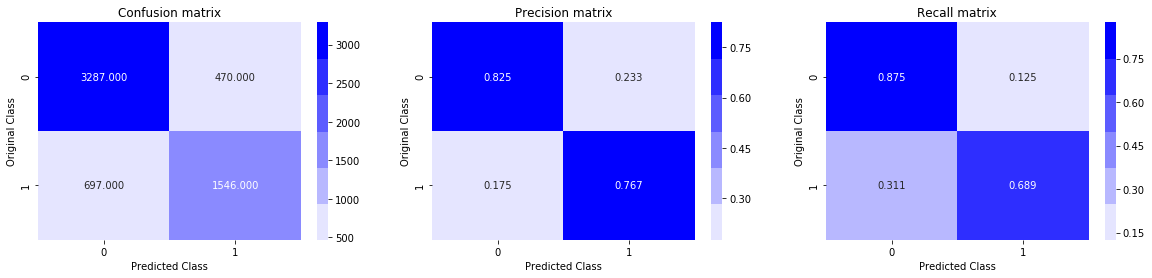

In [179]:
predicted_y = x_model.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predicted_y, labels=[0, 1], eps=1e-15))
plot_confusion_matrix(y_test, x_model.predict(X_test))

### Observations
1. Test log loss has been reduced to 0.37 from 0.38
2. Precision & Recall values have been improved in XGBoost with hyper parameter tuning

<table align="centre">
  <tr>
    <th width="24%"> Model</th>
    <th>Text Featurisation </th>
    <th>No. of data points</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>Test log loss</th>
  </tr>
  <tr>
    <td>Random model</td>
    <td>weighted Tf-Idf vectors</td>
    <td>30K</td>
    <td>0.374</td>
    <td>0.498</td>
    <td>0.882</td>
  </tr>
  <tr>
    <td>Logistic Regression (with hyper paramter tuning)</td>
    <td>weighted Tf-Idf vectors</td>
    <td>30K</td>
    <td>0.693</td>
    <td>0.286</td>
    <td>0.574</td>
  </tr>
  <tr>
    <td>Linear SVM (with hyper paramter tuning)</td>
    <td>weighted Tf-Idf vectors</td>
    <td>30K</td>
    <td>0.740</td>
    <td>0.380</td>
    <td>0.539</td>
  </tr>
  <tr>
    <td>Logistic Regression (with hyper paramter tuning)</td>
    <td>simple Tf-Idf vectors</td>
    <td>20K</td>
    <td>0.718</td>
    <td>0.668</td>
    <td>0.426</td>
  </tr>
  <tr>
    <td>Linear SVM (with hyper paramter tuning)</td>
    <td>simple Tf-Idf vectors</td>
    <td>20K</td>
    <td>0.758</td>
    <td>0.616</td>
    <td>0.423</td>
  </tr>
  <tr>
    <td>XGBoost (without hyperparamter tuning)</td>
    <td>simple Tf-Idf vectors</td>
    <td>20K</td>
    <td>0.762</td>
    <td>0.677</td>
    <td>0.38</td>
  </tr>
  <tr  style="background-color: #c9f5c9;">
    <td><b>XGBoost (with hyperparamter tuning)</b></td>
    <td><b>simple Tf-Idf vectors</b></td>
    <td><b>20K</b></td>
    <td><b>0.767</b></td>
    <td><b>0.689</b></td>
    <td><b>0.37</b></td>
  </tr>
</table> 

# Overall Observations
1. By comparing all the parameters (number of data points, precision, recall, & test log loss values), it is found that <b>XGBoost with hyperparameter tuning (simple Tf-Idf featurisation)</b> performed very well with a test log loss of 0.37

<i>Any input/suggestions are most welcome @[Kalsi](mailto:sachinkalsi15@gmail.com)</i>